In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Hides the GPU from TensorFlow
tf.config.set_visible_devices([], 'GPU') 

# Base path for the dataset
dataset_path = 'data/aclImdb'

train_dataset = keras.utils.text_dataset_from_directory(os.path.expanduser(dataset_path), batch_size=32)    #batch size needs to be changed here
valid_dataset = keras.utils.text_dataset_from_directory(os.path.expanduser(dataset_path), batch_size=32)    #batch size needs to be changed here


# 1. Prepare text data from dataset
texts = []
labels = []

for text_batch, label_batch in train_dataset:
    for text, label in zip(text_batch.numpy(), label_batch.numpy()):
        texts.append(text.decode('utf-8'))
        labels.append([label]) # Convert to list for consistency

print(f"Number of training examples: {len(texts)}")
print(f"Example text: {texts[0][:100]}...")
print(f"Example label: {labels[0]}")

# 2. Tokenize and pad

max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)

# 3. Load GloVe embeddings
embedding_dim = 50
embeddings_index = {}

glove_path = 'glove.6B.50d.txt'
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
 
# 4. Prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 100005 files belonging to 2 classes.
Found 100005 files belonging to 2 classes.


2025-05-15 17:20:08.257941: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of training examples: 100005
Example text: This was another one of those shows that I watched to root out the positive elements, and because I'...
Example label: [0]


In [ ]:
## CHANGE FROM HERE ONWARDS

# 5. Build a simple model
model = models.Sequential([
    layers.InputLayer(input_shape=(max_len,)),
    layers.Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    layers.Conv1D(64, 3, activation='relu'),  # Add local feature extraction
    layers.GlobalMaxPooling1D(),  # Max pooling captures the most important features
    layers.Dropout(0.2),  # Add regularization to prevent overfitting
    layers.Dense(32, activation='relu'),  # Increase from 16 to 32
    layers.Dense(16, activation='relu'),  # Add another layer
    layers.Dropout(0.2),  # Additional dropout
    layers.Dense(y.shape[1], activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'precision', 'recall']  # Added AUC metric for better evaluation
)

model.summary()



# 6. Train
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, verbose=1, validation_split=0.2, callbacks=[early_stop])


# 6.B STORE MODEL
model.save('model.keras')

In [4]:
from tensorflow.keras import models, layers, optimizers, callbacks

# 5. Build a simple (now richer) model
model = models.Sequential([
    layers.InputLayer(input_shape=(max_len,)),

    # pre-trained embedding, frozen
    layers.Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),

    # 1st convolutional block
    layers.Conv1D(128, 5, padding='same', activation='relu'),
    layers.BatchNormalization(),

    # 2nd convolutional block
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.3),

    # fully-connected head
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(y.shape[1], activation='sigmoid')
])

# compile with a lower LR for finer updates
opt = optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

model.summary()

# 6. Train with extended patience and LR reduction on plateau
early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,
    mode='max',
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max'
)

history = model.fit(
    X, y,
    epochs=20,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,065 (2.15 MB)

 Trainable params: 63,553 (248.25 KB)

 Non-trainable params: 500,512 (1.91 MB)

Epoch 1/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - AUC: 0.5013 - accuracy: 0.5792 - loss: 0.7813 - val_AUC: 0.4955 - val_accuracy: 0.7483 - val_loss: 0.5728 - learning_rate: 1.0000e-04
Epoch 2/20
  25/2501 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - AUC: 0.5075 - accuracy: 0.7166 - loss: 0.6163

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


2501/2501 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - AUC: 0.5052 - accuracy: 0.7281 - loss: 0.6034 - val_AUC: 0.4954 - val_accuracy: 0.7483 - val_loss: 0.5748 - learning_rate: 1.0000e-04
Epoch 3/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - AUC: 0.5002 - accuracy: 0.7418 - loss: 0.5874 - val_AUC: 0.4947 - val_accuracy: 0.7483 - val_loss: 0.5752 - learning_rate: 1.0000e-04
Epoch 4/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - AUC: 0.5007 - accuracy: 0.7486 - loss: 0.5775 - val_AUC: 0.4924 - val_accuracy: 0.7483 - val_loss: 0.5740 - learning_rate: 1.0000e-04
Epoch 5/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - AUC: 0.5036 - accuracy: 0.7485 - loss: 0.5738 - val_AUC: 0.4955 - val_accuracy: 0.7483 - val_loss: 0.5720 - learning_rate: 1.0000e-04
Epoch 6/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - AUC: 0.5062 - accuracy: 0.7486 - loss: 0.5715 - val_AUC: 0.4998 - val_accuracy: 0.7483 - val_loss: 0.5714 - learning_rate: 1.0000e-04
Epoch 7/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step -

## CHANGED MAX LENGTH OF TEXT TO 1000 


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Hides the GPU from TensorFlow
tf.config.set_visible_devices([], 'GPU') 

# Base path for the dataset
dataset_path = 'data/aclImdb'

train_dataset = keras.utils.text_dataset_from_directory(os.path.expanduser(dataset_path), batch_size=32)    #batch size needs to be changed here
valid_dataset = keras.utils.text_dataset_from_directory(os.path.expanduser(dataset_path), batch_size=32)    #batch size needs to be changed here


# 1. Prepare text data from dataset
texts = []
labels = []

for text_batch, label_batch in train_dataset:
    for text, label in zip(text_batch.numpy(), label_batch.numpy()):
        texts.append(text.decode('utf-8'))
        labels.append([label]) # Convert to list for consistency

print(f"Number of training examples: {len(texts)}")
print(f"Example text: {texts[0][:100]}...")
print(f"Example label: {labels[0]}")

# 2. Tokenize and pad

max_words = 10000
max_len = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)

# 3. Load GloVe embeddings
embedding_dim = 50
embeddings_index = {}

glove_path = 'glove.6B.50d.txt'
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
 
# 4. Prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [9]:
from tensorflow.keras import models, layers, optimizers, callbacks

# 5. Build a simple (now richer) model
model2 = models.Sequential([
    layers.InputLayer(input_shape=(max_len,)),

    # pre-trained embedding, frozen
    layers.Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),

    # 1st convolutional block
    layers.Conv1D(128, 5, padding='same', activation='relu'),
    layers.BatchNormalization(),

    # 2nd convolutional block
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.3),

    # fully-connected head
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(y.shape[1], activation='sigmoid')
])

# compile with a lower LR for finer updates
opt = optimizers.Adam(learning_rate=1e-4)
model2.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

model2.summary()

# 6. Train with extended patience and LR reduction on plateau
early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,
    mode='max',
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max'
)

history = model2.fit(
    X, y,
    epochs=20,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1000, 50)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1000, 128)      │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1000, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,065 (2.15 MB)

 Trainable params: 63,553 (248.25 KB)

 Non-trainable params: 500,512 (1.91 MB)

Epoch 1/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 156s 62ms/step - AUC: 0.5045 - accuracy: 0.5828 - loss: 0.7516 - val_AUC: 0.5111 - val_accuracy: 0.7524 - val_loss: 0.5687 - learning_rate: 1.0000e-04
Epoch 2/20
   2/2501 ━━━━━━━━━━━━━━━━━━━━ 2:37 63ms/step - AUC: 0.3972 - accuracy: 0.6719 - loss: 0.6836

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 415/2501 ━━━━━━━━━━━━━━━━━━━━ 2:10 62ms/step - AUC: 0.4783 - accuracy: 0.7231 - loss: 0.6164

KeyboardInterrupt: 

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 50)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 128)      │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1000, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,173 (2.64 MB)

 Trainable params: 63,553 (248.25 KB)

 Non-trainable params: 500,512 (1.91 MB)

 Optimizer params: 127,108 (496.52 KB)

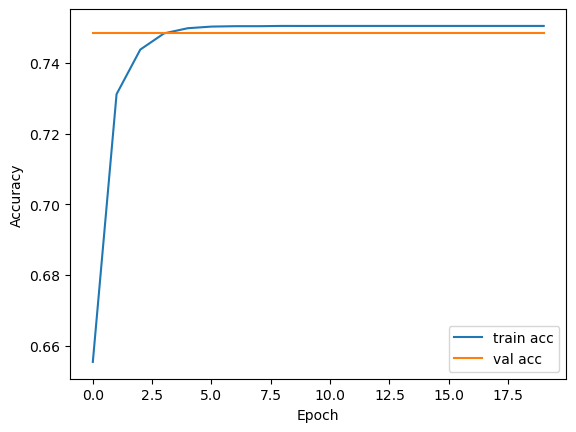

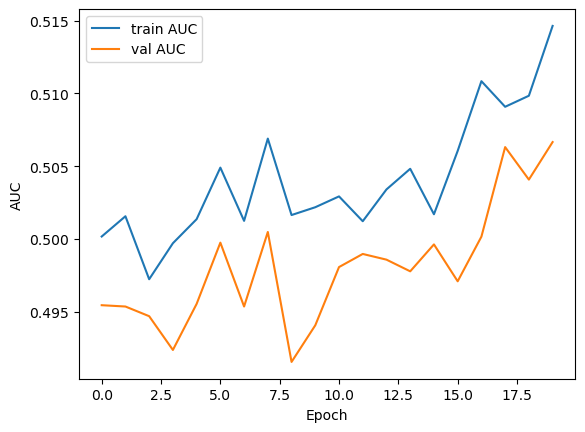

In [10]:
# history.history might look like:
# {'loss': […], 'accuracy': […], 'AUC': […],
#  'val_loss': […], 'val_accuracy': […], 'val_AUC': […]}

import matplotlib.pyplot as plt

# plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

# plot AUC
plt.plot(history.history['AUC'], label='train AUC')
plt.plot(history.history['val_AUC'], label='val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.legend(); plt.show()